#### Computation de différentes relation "plus proche" entre les différents objets

---- PROCESSUS À REVOIR ! ----

Objectifs :

- Génération de relations "plus proche point géospatial" entre différents objets, pour la computation des scores :
    - CITY / ROAD_POINT : tous les points routes à moins de 500m (correction : à moins de 5km)
    - OU, si impossible, les maximun 2 points routes à moins de 5km (correction : à moins de 7km)
    - OU, si impossible, les maximun 1 points routes à moins de 30km

Imports :

In [1]:
import geopandas as gpd
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px


from neo4j import GraphDatabase, basic_auth

Neo4j session :

In [2]:
PASSWORD_NEO4J = 'passwordneo4j'

In [3]:
driver = GraphDatabase.driver(
  "bolt://localhost:7687",
  auth=basic_auth("neo4j", PASSWORD_NEO4J))

---

----

##### Neo4j requests :

Requête ardoise :

In [6]:
""" def delete_all_edges_NEARLY_TO(tx):

    query = "MATCH ()-[r:NEARLY_TO]-() \
            DELETE r \
            RETURN count(*) AS COUNT"

    result = tx.run(query)
    return result.data() """

In [44]:
def set_travel_time_zero(tx):

    query = "MATCH ()-[n:NEARLY_TO]-() \
            SET n.travel_time = 0.0 \
            RETURN count(*) AS count"
    
    result = tx.run(query)
    return result.data()

In [4]:
def get_all_road_points(tx):

    query = "MATCH (p:ROAD_POINT) \
            RETURN ID(p) as id, p.x as x , p.y as y"
    
    result = tx.run(query)
    return result.data()

In [5]:
def get_all_communes(tx):

    query = "MATCH (n:CITY) RETURN n.insee as insee, n.x as x, n.y as y"

    result = tx.run(query)
    return result.data()


In [6]:
def get_all_communes_with_no_nearly_road(tx):

    query = "MATCH (n:CITY) WHERE NOT EXISTS ((n)-[:NEARLY_TO]-()) RETURN n.insee as insee"

    result = tx.run(query)
    return result.data()


In [8]:
def create_relationship_NEARLY_TO(tx, props_list):

    query = "   UNWIND $props_list AS map \
                MATCH (p:ROAD_POINT) WHERE ID(p)=map.id \
                MATCH (c:CITY {insee:map.insee}) \
                CREATE (c)-[:NEARLY_TO]->(p) \
                RETURN count(p) AS COUNT"
    
    result = tx.run(query, props_list=props_list)
    return result.data()
    

In [101]:
def create_edge_NEARLY_TO_just_for_one_insee(tx, insee, DISTANCE_NEARLY_TO):

    query = "   MATCH (n:CITY) WHERE n.insee = " + str(insee) + " \
                MATCH (p:ROAD_POINT) WHERE point.distance(n.location, p.location) < " + str(DISTANCE_NEARLY_TO) + " \
                CREATE (n)-[r:NEARLY_TO]->(p) \
                RETURN count(*) as count"

    result = tx.run(query)
    return result.data()

---

IMPORT DES COMMUNES MUNIES DE LEUR GEOMETRIES :

In [9]:
with driver.session() as session:

    count_list = []

    result = session.execute_write(get_all_communes)

driver.close()

In [10]:
communes_graph = pd.DataFrame(result)

In [11]:
communes_graph

,insee,x,y
0,62053,2.143174,50.582893
1,80284,3.012390,49.717236
2,31290,0.610023,42.876728
3,28400,1.514000,48.094594
4,37220,0.099943,47.193507
...,...,...,...
34455,03170,3.092677,46.506657
34456,14394,-0.162877,49.015889
34457,29115,-3.895241,48.302289
34458,49308,-0.496845,47.370808


Import du dataframe communes doté des géométries :

In [12]:
data_path = "./../data_communes/communes_geometry.feather"

In [13]:
communes = gpd.read_feather(data_path).reset_index()

In [14]:
communes.head()

,index,insee,nom,wikipedia,surf_ha,geometry
0,0,2B222,Pie-d'Orezza,fr:Pie-d'Orezza,573.0,"POLYGON ((9.32017 42.38507, 9.32028 42.38510, ..."
1,1,2B137,Lano,fr:Lano,824.0,"POLYGON ((9.20010 42.39013, 9.20014 42.39014, ..."
2,2,2B051,Cambia,fr:Cambia,833.0,"POLYGON ((9.27757 42.37509, 9.27758 42.37512, ..."
3,3,2B106,Érone,fr:Érone,393.0,"POLYGON ((9.25119 42.37605, 9.25132 42.37603, ..."
4,4,2B185,Oletta,fr:Oletta,2674.0,"POLYGON ((9.28340 42.66273, 9.28345 42.66273, ..."


In [72]:
communes.loc[communes["insee"]=='69063',:]

,index,insee,nom,wikipedia,surf_ha,geometry
11444,11444,69063,Collonges-au-Mont-d'Or,fr:Collonges-au-Mont-d'Or,380.0,"POLYGON ((4.82695 45.82333, 4.82695 45.82361, ..."


Cast pour la jointure :

In [15]:
communes_graph["insee"] = communes_graph["insee"].apply(lambda v : str(v) if len(str(v))!=4 else "0" + str(v))


In [16]:
communes_graph.loc[communes_graph["insee"]=="03170",:]

,insee,x,y
34455,03170,3.092677,46.506657


In [17]:
communes.loc[communes["insee"]=="03170",:]

,index,insee,nom,wikipedia,surf_ha,geometry
518,518,03170,Meillers,fr:Meillers,2361.0,"POLYGON ((3.06229 46.53816, 3.06248 46.53831, ..."


Jointure à gauche (pour ne garder que les communes existantes dans le graph qui sont donc métropolitaines)

In [18]:
gdf_communes = communes_graph.merge(communes[['insee', 'geometry']], how='left', on="insee" )

In [19]:
gdf_communes = gpd.GeoDataFrame(gdf_communes)

In [20]:
gdf_communes.loc[gdf_communes["insee"]=="03170",:]

,insee,x,y,geometry
34455,03170,3.092677,46.506657,"POLYGON ((3.06229 46.53816, 3.06248 46.53831, ..."


Visualisation de l'ensemble des communes de France (attention : computation 1 - 2 mins)

<Axes: >

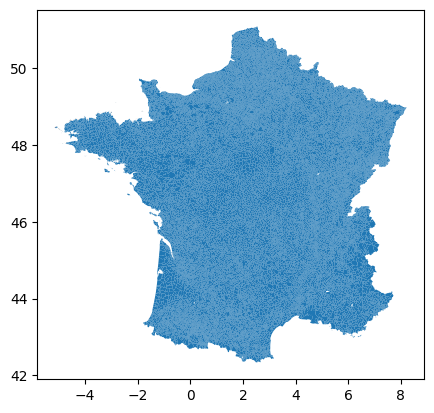

In [21]:
gdf_communes.plot()

---

IMPORT DES POINTS ROUTES DU GRAPH :

In [22]:
with driver.session() as session:

    count_list = []

    result = session.execute_write(get_all_road_points)

driver.close()

In [23]:
df_rp = pd.DataFrame(result)

In [24]:
df_rp

,id,x,y
0,0,5.609986,45.612495
1,1,5.610649,45.618184
2,2,5.610845,45.618820
3,3,5.643739,45.640536
4,4,5.666526,45.717441
...,...,...,...
523303,523303,4.908456,44.269882
523304,523304,4.763913,44.178254
523305,523305,4.764050,44.178234
523306,523306,4.825432,44.096210


Conversion en geopandas dataframe :

In [25]:
gdf_rp = gpd.GeoDataFrame(df_rp, geometry=gpd.points_from_xy(df_rp.x, df_rp.y), crs="EPSG:4326")

----

JOINTURE SPATIALE SOUS GEOPANDAS :

On prend un rayon de 5km tout autour des points routes

Projection dans un système métrique (EPSG:3857), agrandissement, puis re-projection au système d'origine (EPSG:4326)

In [26]:
gdf_rp_2 = gdf_rp.to_crs(crs=3857)

In [27]:
gdf_rp_2 = gdf_rp_2.buffer(5000)

In [28]:
import copy

In [29]:
gdf_rp_3 = copy.copy(gdf_rp)

In [30]:
gdf_rp_3.geometry = gdf_rp_2.to_crs(crs=4326).geometry

In [31]:
gdf_rp_3.head()

,id,x,y,geometry
0,0,5.609986,45.612495,"POLYGON ((5.65490 45.61249, 5.65469 45.60942, ..."
1,1,5.610649,45.618184,"POLYGON ((5.65556 45.61818, 5.65535 45.61510, ..."
2,2,5.610845,45.618820,"POLYGON ((5.65576 45.61882, 5.65554 45.61574, ..."
3,3,5.643739,45.640536,"POLYGON ((5.68865 45.64054, 5.68844 45.63746, ..."
4,4,5.666526,45.717441,"POLYGON ((5.71144 45.71744, 5.71123 45.71437, ..."


On obtient bien maintenant des cercles (de rayons 5km) pour chaque point

Jointure :

In [32]:
df_join = gdf_communes.sjoin(gdf_rp_3, how="inner")

In [33]:
df_join.head()

,insee,x_left,y_left,geometry,index_right,id,x_right,y_right
0,62053,2.143174,50.582893,"POLYGON ((2.09178 50.56119, 2.09183 50.56153, ...",236362,236362,2.153916,50.533628
3783,62790,2.152329,50.533161,"POLYGON ((2.12567 50.53886, 2.12568 50.53892, ...",236362,236362,2.153916,50.533628
11641,62453,2.178727,50.530760,"POLYGON ((2.16401 50.53085, 2.16407 50.53091, ...",236362,236362,2.153916,50.533628
13195,62364,2.134929,50.515039,"POLYGON ((2.05751 50.51449, 2.05872 50.51483, ...",236362,236362,2.153916,50.533628
13257,62562,2.165547,50.545919,"POLYGON ((2.13629 50.54389, 2.13629 50.54390, ...",236362,236362,2.153916,50.533628


In [34]:
len(df_join)

3978131

Presque 4 millions de relations à créer ! Tout va bien...

In [ ]:
with driver.session() as session:

    count_list = []

    result = session.execute_write(get_all_road_points)

driver.close()

----

REQUETE POUR CREATION DES RELATIONS "NEARLY_TO" SOUS NEO4J

On épure le dataframe pour préparer les requêtes sous Neo4j

In [35]:
df_records = df_join[['insee','id']]

On cast à nouveau la colonne "insee" pour la reconvertir en Integer, comme dans le graph initial.

In [36]:
df_records['insee'] = df_records['insee'].apply(lambda v : int(v))

/tmp/ipykernel_7183/1365095575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_records['insee'] = df_records['insee'].apply(lambda v : int(v))


In [38]:
print("conversion of objects to parameters list for neo4j...")

props_list = df_records.to_dict("records")

conversion of objects to parameters list for neo4j...


In [39]:
BATCH_SIZE = 50000

In [40]:
# --- Batch function ---

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [41]:
with driver.session() as session:

    count_list = []

    # Batch the writing session :

    for props_batch in batch(props_list, BATCH_SIZE):
        result = session.write_transaction(create_relationship_NEARLY_TO, props_batch)
        count_list.append(result[0]['COUNT'])
        nb_updates = sum(count_list)
        print(f'Number of nodes created : {nb_updates}...')

        

    driver.close()

print(f'Bath_list: {count_list}')

print(f'Total Numbers of nodes created/updates: {nb_updates}')

/tmp/ipykernel_7183/890060475.py:8: DeprecationWarning: write_transaction has been renamed to execute_write
  result = session.write_transaction(create_relationship_NEARLY_TO, props_batch)


Number of nodes created : 50000...
Number of nodes created : 100000...
Number of nodes created : 150000...
Number of nodes created : 200000...
Number of nodes created : 250000...
Number of nodes created : 300000...
Number of nodes created : 350000...
Number of nodes created : 400000...
Number of nodes created : 450000...
Number of nodes created : 500000...
Number of nodes created : 550000...
Number of nodes created : 600000...
Number of nodes created : 650000...
Number of nodes created : 700000...
Number of nodes created : 750000...
Number of nodes created : 800000...
Number of nodes created : 850000...
Number of nodes created : 900000...
Number of nodes created : 950000...
Number of nodes created : 1000000...
Number of nodes created : 1050000...
Number of nodes created : 1100000...
Number of nodes created : 1150000...
Number of nodes created : 1200000...
Number of nodes created : 1250000...
Number of nodes created : 1300000...
Number of nodes created : 1350000...
Number of nodes creat

Une génération de 4 presque millions de relations qui devrait rester extrêmement rapide (5 minutes de mon côté)

Vérification des communes orphelines (sans relations "NEARLY_TO" avec au moins 1 point route)

In [46]:
with driver.session() as session:

    count_list = []

    result = session.execute_write(get_all_communes_with_no_nearly_road)

driver.close()

df = pd.DataFrame(result)

In [47]:
df

,insee
0,56152
1,17323
2,73047
3,29084
4,17486
5,48054
6,56086
7,56069
8,17385
9,56085


Après vérification méticuleuse de la liste des 18 communes, elles sont toutes soit des communes situées sur des îles (donc ce ne sont pas des communes de "passage", soit des communes vraiment très isolées dans les montagnes, situées dans des cols escarpés ou cul-de-sac...)

Toute sauf une commune, la Commune de Collonges-au-Mont-d'Or !... qui se situe en plein coeur de lyon. Pour uen raison étrange, Lyon possède un centre sans point route.

On va donc artificiellement créer des relations "NEARLY_TO" avec cette communes pour des points routes proches de 7km. (au lieu de 5km) :

In [103]:
with driver.session() as session:

    result = session.execute_write(create_edge_NEARLY_TO_just_for_one_insee, 69063, 7000)

driver.close()

nb_nodes = result[0]['count']
                
print(f'Total Numbers of edges created: {nb_nodes}')

Total Numbers of edges created: 54


----

Ajout de travel_time en prppriété (tout à zéro en type Float). Ce "travel-time" sera indispensable pour les alogorithmes de plus court chemin. Le temps de trajet des relations "NEARLY TO" sera négligeable.

In [104]:
with driver.session() as session:

    count_list = []

    result = session.execute_write(set_travel_time_zero)

driver.close()

nb_nodes = result[0]['count']
                
print(f'Total Numbers of add propertie: {nb_nodes}')

Total Numbers of add propertie: 7956370


---

----

PARTIE DE TEST (optionnel)

In [73]:
X_LOW = 4.266392

X_HIGH = 5.366894

Y_LOW = 45.433801

Y_HIGH = 46.138016

In [74]:
to_keep = (gdf_rp['x'] > X_LOW) & ((gdf_rp['x'] < X_HIGH)) & (gdf_rp['y'] > Y_LOW) & ((gdf_rp['y'] < Y_HIGH))

gdf_rp_test = gdf_rp.loc[to_keep, :]

In [75]:
len(gdf_rp_test)

9234

In [76]:
gdf_rp_test.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

/tmp/ipykernel_7183/1414254789.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_rp_test.buffer(0.02).plot()


<Axes: >

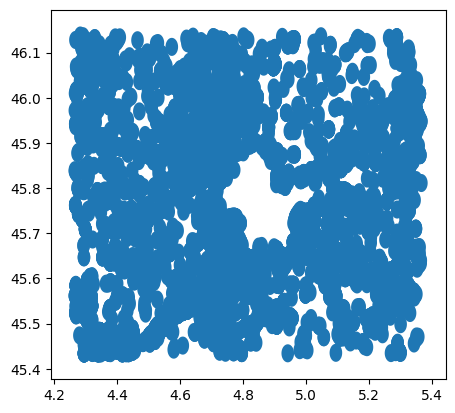

In [52]:
gdf_rp_test.buffer(0.02).plot()

In [77]:
gdf_rp_test_2 = gdf_rp_test.to_crs(crs=3857)

<Axes: >

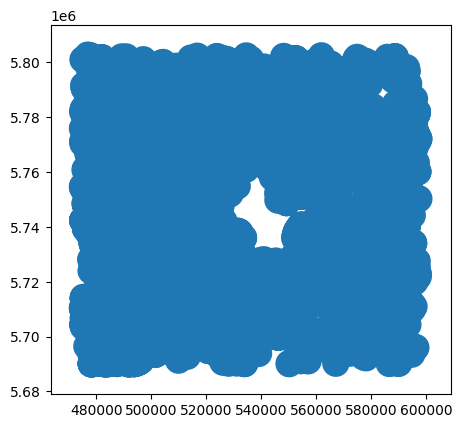

In [78]:
gdf_rp_test_2.buffer(5000).plot()

In [79]:
gdf_rp_test_2 = gdf_rp_test_2.buffer(5000)

In [80]:
import copy

In [81]:
gdf_rp_test_3 = copy.copy(gdf_rp_test)

In [82]:
gdf_rp_test_3.geometry = gdf_rp_test_2.to_crs(crs=4326).geometry

<Axes: >

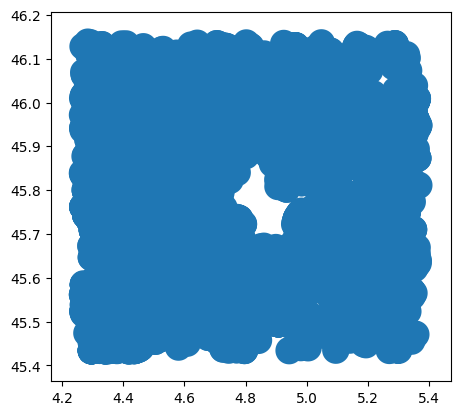

In [83]:
gdf_rp_test_3.plot()

In [84]:
gdf_communes.loc[gdf_communes['insee']=='69063',:]

,insee,x,y,geometry
26121,69063,4.841157,45.822966,"POLYGON ((4.82695 45.82333, 4.82695 45.82361, ..."


In [85]:
to_keep = (gdf_communes['x'] > X_LOW) & ((gdf_communes['x'] < X_HIGH)) & (gdf_communes['y'] > Y_LOW) & ((gdf_communes['y'] < Y_HIGH))

gdf_communes_test = gdf_communes.loc[to_keep, :]

In [86]:
gdf_communes_test

,insee,x,y,geometry
21,38487,4.844174,45.559629,"POLYGON ((4.81602 45.56613, 4.81606 45.56615, ..."
65,01238,4.824100,45.906800,"POLYGON ((4.80350 45.90037, 4.80351 45.90048, ..."
137,69276,4.858310,45.673800,"POLYGON ((4.82932 45.66034, 4.82940 45.66088, ..."
200,69019,4.748655,46.108938,"POLYGON ((4.69084 46.13332, 4.69177 46.13374, ..."
322,69279,5.047562,45.796518,"POLYGON ((5.01304 45.79964, 5.01305 45.79969, ..."
...,...,...,...,...
34109,69122,4.701603,45.912081,"POLYGON ((4.68494 45.90648, 4.68507 45.90685, ..."
34326,42128,4.301470,45.921500,"POLYGON ((4.28326 45.93652, 4.28344 45.93704, ..."
34328,01325,5.188784,45.940261,"POLYGON ((5.12539 45.96830, 5.12543 45.96858, ..."
34398,42055,4.465240,45.596401,"POLYGON ((4.45010 45.58704, 4.45013 45.58708, ..."


<Axes: >

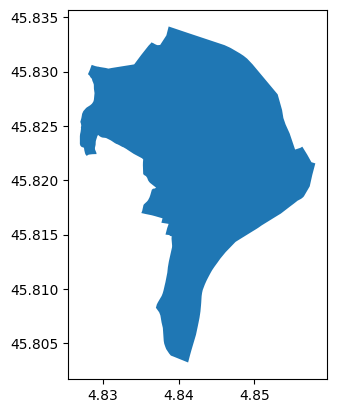

In [91]:
gdf_communes_test.loc[gdf_communes_test["insee"]=='69063',:].plot()

In [88]:
df_join = gdf_communes_test.sjoin(gdf_rp_test_3, how="inner")
df_join

,insee,x_left,y_left,geometry,index_right,id,x_right,y_right
21,38487,4.844174,45.559629,"POLYGON ((4.81602 45.56613, 4.81606 45.56615, ...",28941,28941,4.868996,45.521974
444,38544,4.874770,45.525240,"POLYGON ((4.83589 45.54388, 4.83675 45.54479, ...",28941,28941,4.868996,45.521974
733,69235,4.859964,45.535052,"POLYGON ((4.78858 45.52640, 4.79008 45.52701, ...",28941,28941,4.868996,45.521974
5115,38199,4.907812,45.496399,"POLYGON ((4.89223 45.49226, 4.89224 45.49244, ...",28941,28941,4.868996,45.521974
5471,69007,4.811206,45.488877,"POLYGON ((4.77019 45.50532, 4.77095 45.50546, ...",28941,28941,4.868996,45.521974
...,...,...,...,...,...,...,...,...
32148,69060,4.494008,46.100221,"POLYGON ((4.46693 46.11569, 4.46696 46.11572, ...",48804,48804,4.574349,46.112625
25687,69124,4.571121,46.112225,"POLYGON ((4.53001 46.12107, 4.53006 46.12112, ...",49324,49324,4.524746,46.119717
32148,69060,4.494008,46.100221,"POLYGON ((4.46693 46.11569, 4.46696 46.11572, ...",49324,49324,4.524746,46.119717
25687,69124,4.571121,46.112225,"POLYGON ((4.53001 46.12107, 4.53006 46.12112, ...",49325,49325,4.530218,46.121162


In [89]:
df_test = df_join.loc[df_join['insee']=='69063',:]

ValueError: aspect must be finite and positive 

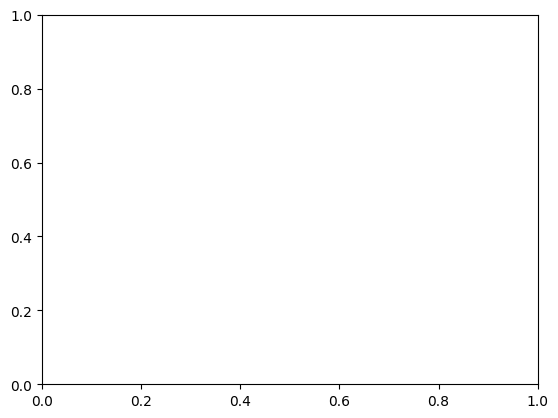

In [90]:
df_test.plot()

In [131]:
df_points_test = gpd.GeoDataFrame(df_test[['x_right', 'y_right']], geometry=gpd.points_from_xy(df_test.x_right, df_test.y_right), crs="EPSG:4326")

In [133]:
df_points_test

,x_right,y_right,geometry
32419,5.484926,43.576321,POINT (5.48493 43.57632)
32419,5.484354,43.592557,POINT (5.48435 43.59256)
32419,5.472590,43.582517,POINT (5.47259 43.58252)
32419,5.472473,43.582559,POINT (5.47247 43.58256)
32419,5.472681,43.582598,POINT (5.47268 43.58260)
...,...,...,...
32419,5.428322,43.547641,POINT (5.42832 43.54764)
32419,5.429799,43.549955,POINT (5.42980 43.54996)
32419,5.426434,43.550309,POINT (5.42643 43.55031)
32419,5.426493,43.550382,POINT (5.42649 43.55038)


<Axes: >

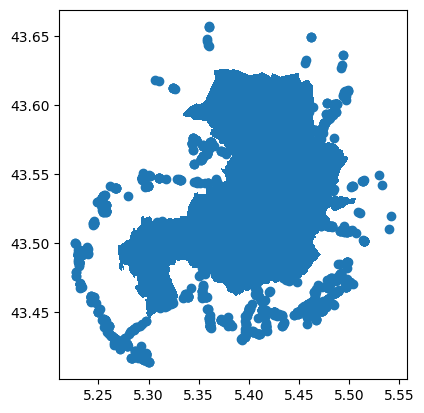

In [134]:
f, ax = plt.subplots()
df_test.plot(ax=ax)
df_points_test.plot(ax=ax)

---

EDGES COMMUNES / ROAD_POINT

Ardoise : pour effacer toute relation "NEARLY_TO" anciennes

In [160]:
with driver.session() as session:

    count_list = []

    result = session.execute_write(delete_all_edges_NEARLY_TO)

driver.close()

print(result) 

[{'COUNT': 0}]
